--- Machine Learning Weather Modeling (RF & SVR) ---
Training ML models on 170 hours of history...
Displaying ML comparison graph...


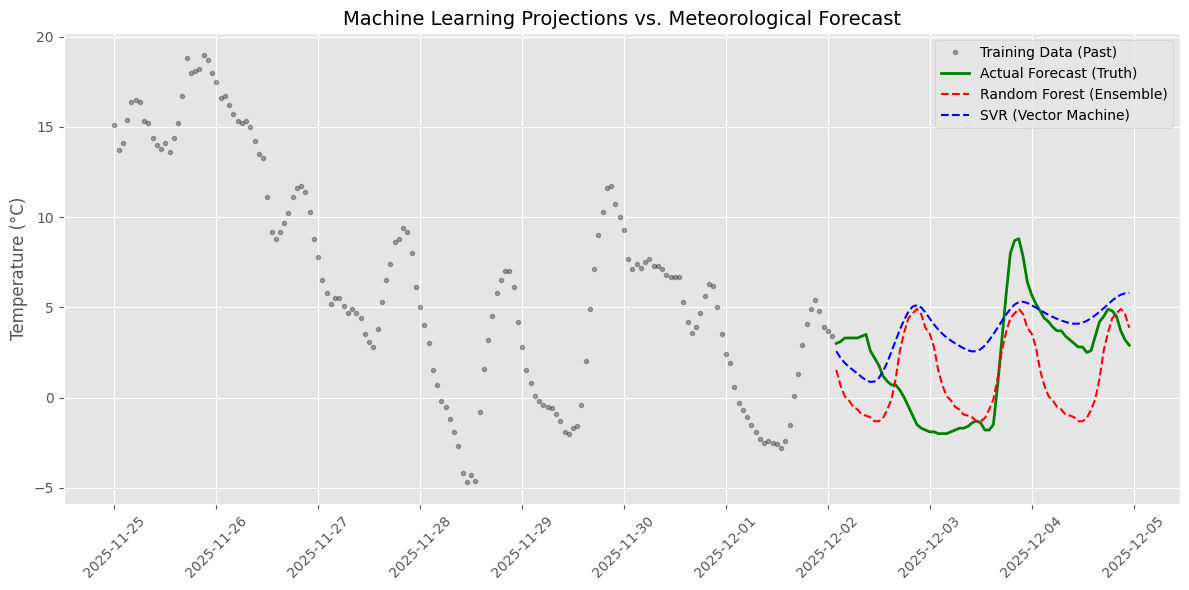


--- Model Insights ---
Random Forest: Captures step-changes and complex interactions well.
SVR: Produces a smoother curve, often generalizing better on trends.


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datetime import datetime

LATITUDE = 36.17
LONGITUDE = -86.78
PAST_DAYS = 7
FORECAST_DAYS = 3

print("--- Machine Learning Weather Modeling (RF & SVR) ---")

url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={LATITUDE}&longitude={LONGITUDE}"
    f"&hourly=temperature_2m"
    f"&past_days={PAST_DAYS}&forecast_days={FORECAST_DAYS}"
    f"&temperature_unit=celsius"
)

response = requests.get(url)
data = response.json()
hourly = data['hourly']

df = pd.DataFrame({
    'time': pd.to_datetime(hourly['time']),
    'temperature': hourly['temperature_2m']
})

df['hour'] = df['time'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['timestamp'] = df['time'].apply(lambda x: x.timestamp())

current_time = datetime.now()
train_df = df[df['time'] < current_time].copy()
test_df = df[df['time'] >= current_time].copy()

features = ['timestamp', 'hour_sin', 'hour_cos']
X_train = train_df[features]
y_train = train_df['temperature']
X_test = test_df[features]
y_test_truth = test_df['temperature']

print(f"Training ML models on {len(train_df)} hours of history...")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
test_df['pred_rf'] = rf_model.predict(X_test)

svr_model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svr_model.fit(X_train, y_train)
test_df['pred_svr'] = svr_model.predict(X_test)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_df['time'], train_df['temperature'], 'k.', alpha=0.3, label='Training Data (Past)')
ax.plot(test_df['time'], test_df['temperature'], 'g-', linewidth=2, label='Actual Forecast (Truth)')
ax.plot(test_df['time'], test_df['pred_rf'], 'r--', label='Random Forest (Ensemble)')
ax.plot(test_df['time'], test_df['pred_svr'], 'b--', label='SVR (Vector Machine)')

ax.set_title('Machine Learning Projections vs. Meteorological Forecast', fontsize=14)
ax.set_ylabel('Temperature (°C)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

print("Displaying ML comparison graph...")
plt.show()

print("\n--- Model Insights ---")
print("Random Forest: Captures step-changes and complex interactions well.")
print("SVR: Produces a smoother curve, often generalizing better on trends.")
